In [1]:
import sys
import os
sys.path.append('../code')
from init_mooc_nb import *
init_notebook()
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import scipy.linalg as la

# Set the path to a folder containing data files, to work with filters as well.
data_folder = 'data/' if os.path.exists('data') and os.path.isdir('data') else '../data/'

def make_kitaev_chain(L=10):
    lat = kwant.lattice.chain()
    sys = kwant.Builder()
    
    def onsite(site, p):
        if not p.disorder:
            return (p.m + 2 * p.t) * pauli.sz
        else:
            rand = p.disorder * kwant.digest.gauss(str(site.tag), p.salt)
            return (p.m + rand + 2 * p.t) * pauli.sz

    def hop(site1, site2, p):
        return -p.t * pauli.sz - 1j * p.delta * pauli.sy
    
    sys[(lat(i) for i in range(L))] = onsite
    sys[kwant.HoppingKind((1,), lat)] = hop
    
    sym = kwant.TranslationalSymmetry((1,))
    lead = kwant.Builder(sym)

    # The leads are precalculated.
    lead[lat(0)] = onsite
    lead[kwant.HoppingKind((1,), lat)] = hop
    
    sys.attach_lead(lead)
    sys.attach_lead(lead.reversed())
    sys = sys.finalized()
    sys = sys.precalculate(args=[SimpleNamespace(t=1.0, m=0.0, delta=1.0, disorder=0)])
    
    return sys


def phase_diagram(L, ms, p, num_average=100):
    sys = make_kitaev_chain(L)

    # Adjust the reflection phase such that it's 0 for trivial system.
    trivial = SimpleNamespace(m=10., t=1.0, delta=1.0, disorder=0, salt='')
    phase = kwant.smatrix(sys, args=[trivial]).data[0, 0]
    phase /= abs(phase)
    data = []
    for p.m in ms:
        qt = []
        for p.salt in map(str, range(num_average)):
            s = kwant.smatrix(sys, args=[p]).data
            qt.append(((s[0, 0] / phase).real, abs(s[0, 1])**2))
        qt = np.mean(qt, axis=0)
        data.append(qt)

    return np.array(data).T

Populated the namespace with:
np, matplotlib, kwant, holoviews, init_notebook, interact, display_html, plt, pf, SimpleNamespace, pprint_matrix, scientific_number, pretty_fmt_complex
from code/edx_components:
MoocVideo, PreprintReference, MoocDiscussion, MoocCheckboxesAssessment, MoocMultipleChoiceAssessment, MoocPeerAssessment, MoocSelfAssessment
from code/functions:
spectrum, hamiltonian_array, h_k, pauli


Press this button to show/hide the code used in the notebook:

**No content above this line is visible in edX**

# Introduction

The scaling flow of topological insulators is introduced by Alexander Altland from the University of Cologne

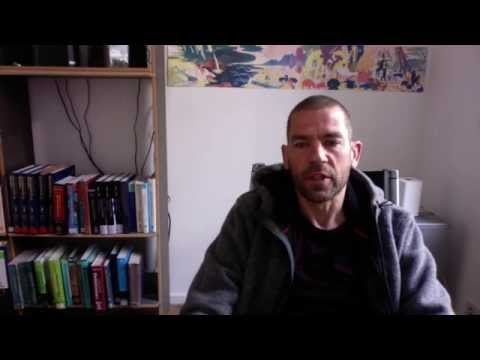

In [2]:
MoocVideo("8gkERY6hXTU", src_location="9.2-intro")

# A toy model for two-parameter scaling: the disordered Kitaev chain

Before we learn what happens to topological insulators in the presence of disorder, let's decide on a specific example for concreteness.

Topology makes the behavior of disordered systems richer, however a careful simulation of properties of disordered topological insulators may take weeks, since we need not only to take large system sizes (we need to consider the lengths much larger than mean free path), but also we need to average over disorder.

Luckily, unlike in the non-topological case, a one-dimensional system can already show interesting properties in the presence of disorder, so we can just reuse the familiar Kitaev chain and add disorder to it.

It is nothing but the same 1D tight-binding model that we saw in week one,
 
$$
H = \sum_n (\mu_n + 2t + m) \tau_z\left|n\right\rangle\left\langle n\right|-\sum_n \left[(t\tau_z+i\Delta\tau_y)\,\left|n\right\rangle\left\langle n\!+\!\!1 \right| + \textrm{h.c.}\right].
$$

For convenience, we introduced a mass $m$ that corresponds to the gap in the Dirac equation. The phase transition happens at $m=0$, and $m<0$ corresponds to the topological phase with Majorana modes at the end.

The only difference from what we used before is that now the chemical potential $\mu_n$ varies randomly from site to site. For example, we can sample the values $\mu_n$ from a Gaussian distribution with mean value $\mu_0 $ and standard deviation $U$.

# The simpler effect of disorder

In addition to transmission through a finite chain we can now compute its topological invariant $\mathcal{Q}$.

Just as a reminder: $\mathcal{Q} = \det r$, with $r$ is the reflection matrix from one end of a finite Kitaev chain.

We know that $\mathcal{Q}=-1$ in the topological phase and $\mathcal{Q}=+1$ in the trivial phase. Now, in the presence of disorder, the value of $\mathcal{Q}$ in a finite size system can in principle depend on the particular disorder realization. So just like calculating average conductance, we can average the topological invariant over disorder to describe how topological properties depend on it.

Whenever $\langle Q\rangle = \pm 1$, we know that the system is in one of the two insulating phases and there is no reflection whatsoever.

Let's try the most obvious thing and see what happens to  $\langle Q\rangle$, as we increase disorder strength.

So below we see $\mathcal{Q}$ averaged over 100 different realizations in a disordered Kitaev chain with 30 sites as we gradually increase $U$:

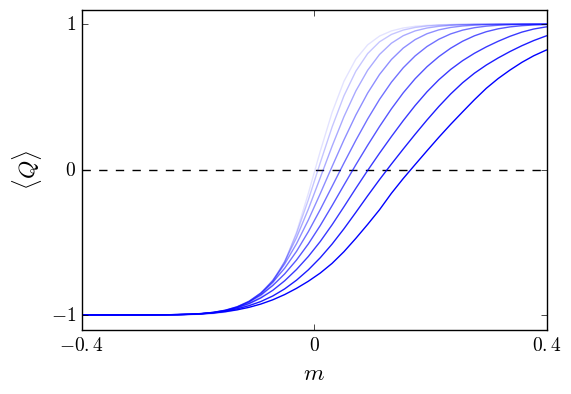

In [3]:
if os.path.exists(data_folder + 'first_plot_data_ms.dat') and os.path.exists(data_folder + 'first_plot_data_qs.dat'):
    ms = np.loadtxt(data_folder + 'first_plot_data_ms.dat')
    qs = np.loadtxt(data_folder + 'first_plot_data_qs.dat')
else:
    # This cell generates data
    p = SimpleNamespace(t=1.0, delta=1.0)
    ms = np.linspace(-.5, .5, 50)
    qs = [phase_diagram(30, ms, p)[0] for p.disorder in np.linspace(0, .8, 10)]
    np.savetxt(data_folder + 'first_plot_data_ms.dat', ms)
    np.savetxt(data_folder + 'first_plot_data_qs.dat', qs) 

fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle('alpha', np.linspace(0, 1, len(qs)))

for q in qs:
    ax.plot(ms, q)
    
ax.set_xlabel('$m$')
ax.set_ylabel(r'$\langle Q \rangle$')

evals = [-0.4, 0, 0.4]
ax.set_xticks(evals)
ax.set_xticklabels(["${0}$".format(i) for i in evals]);

evals = [-1, 0, 1]
ax.set_yticks(evals)
ax.set_yticklabels(["${0}$".format(i) for i in evals]);

ax.set_xlim(-.4, .4)
ax.set_ylim(-1.1, 1.1)

ax.hlines(0, ax.get_xlim()[0], ax.get_xlim()[1], linestyles='dashed');

(Darker color corresponds to larger $U$.)

What you see is that far away from the transition, when the gap in the clean limit is very large, disorder does not matter. Around the transition, the average value of $\mathcal{Q}$ changes from $-1$ and $+1$.

Increasing disorder changes two things: 
* It makes the width of the region where the transition happens larger. This we can understand relatively well, in a finite system adding fluctuations just means we can be (un)lucky and get an opposite value of the topological invariant.
* It shifts the separation point between trivial and topological phases towards positive $m$. This looks much more curious: if we start with a trivial and insulating system and add disorder, it appears we can make this system topological!

The second effect, despite looking mysterious, appears just because the disorder changes the effective values of the Hamiltonian parameters. For small $U$, this can be understood in terms of the [Born approximation](https://en.wikipedia.org/wiki/Born_approximation), which allows to compute *effective* disorder-averaged band structure parameters, given the properties of disorder. The lowest order correction to $m$ for the disorder Kitaev chain is simply $m_\textrm{eff} - m \sim -U^2$, and weak disorder indeed drives the system to a topologically nontrivial state by lowering the effective value of the mass.

Since this phenomenon appears with disorder, it was initially dubbed "topological Anderson insulator". This name is certainly not accurate: the band structure parameters approach the effective ones on the length scale of mean free path, and before the Anderson scaling flow begins.

In [4]:
question = (r"What would happen if instead of $\det r$ we use $sign \det r$ for invariant?")
answers = ["We would get a step function instead of a smooth curve.",
           r"Not well-defined because $\det r$ becomes complex.",
           "The $Q=\pm 1$ plateaus cancel and give $Q=0$.",
           "The curve is qualitatively the same."]

explanation = (r"Each disorder realization get $\textrm{det} r\sim \pm 1$ except near the transition. So adding sign doesn't affect "
               "the invariant for most disorder realizations. The intermediate values result from averaging over different "
               "realizations.")

MoocMultipleChoiceAssessment(question=question, answers=answers, correct_answer=3, explanation=explanation)

MoocMultipleChoiceAssessment(**{'question': 'What would happen if instead of $\\det r$ we use $sign \\det r$ for invariant?', 'display_name': 'Question', 'correct_answer': 3, 'explanation': "Each disorder realization get $\\textrm{det} r\\sim \\pm 1$ except near the transition. So adding sign doesn't affect the invariant for most disorder realizations. The intermediate values result from averaging over different realizations.", 'answers': ['We would get a step function instead of a smooth curve.', 'Not well-defined because $\\det r$ becomes complex.', 'The $Q=\\pm 1$ plateaus cancel and give $Q=0$.', 'The curve is qualitatively the same.'], 'max_attempts': 2})

# Two parameter scaling in one dimension

Speaking of the scaling flow: the scaling hypothesis appears to be very powerful, does the topology have any impact on it?

We can understand some limits. First of all, if $g\gg 1$, the system is a metal, and there can hardly be any trace of topology left. However when $g \lesssim 1$, the system can become one out of several topologically distinct types of insulators, and we can expect some sort of transition between different insulating phases.

The rational assumption at this point is to assume that the scaling hypothesis still holds, but in addition to $g$ it depends on the average topological invariant of the disordered ensemble $\langle \mathcal{Q} \rangle$.

Just like in the case of the non-topological phases, there is no universal proof that this form of scaling flow is correct. Instead, there is a vast amount of mixed numerical and analytical evidence that this is correct.

Let's try and verify our hypothesis by constructing the scaling flow of the disordered Kitaev chain. We can do it in the following way:

* Choose a given disorder strength $U$, a given length $L$, and a set of values $\{\mu\}$ for the chemical potential. For each of these values, we compute $\langle \mathcal{Q} \rangle$ and the average transmission $\langle T \rangle$ over a large number of disorder realizations (as large as possible, in our case 1000). This gives us a set of starting points on the $(\langle \mathcal{Q} \rangle, \langle T \rangle)$ plane.

* Increase the chain length $L$, and compute $\langle \mathcal{Q} \rangle, \langle T \rangle$ again for all the values $\{\mu\}$. We obtain a second set of points on the plane.

* Join the points corresponding to the same value of $\mu$.

* Increase again the length $L$, and so on...

Here's what we get:

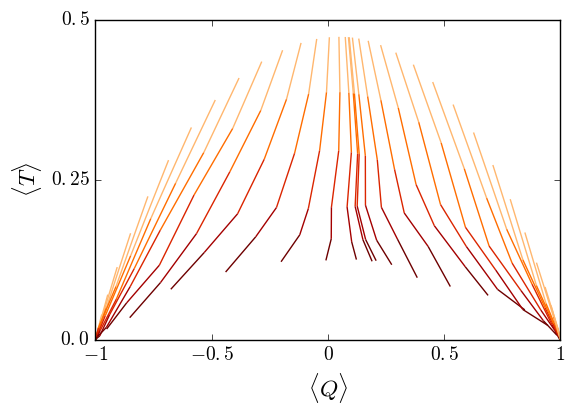

In [5]:
if os.path.exists(data_folder + 'scaling_data_qs.dat') and os.path.exists(data_folder + 'scaling_data_ts.dat'):
    qs = np.loadtxt(data_folder + 'scaling_data_qs.dat')
    ts = np.loadtxt(data_folder + 'scaling_data_ts.dat')
else:
    p = SimpleNamespace(t=1.0, delta=1.0, disorder=0.8)
    Ls = np.array(np.logspace(np.log10(10), np.log10(180), 6), dtype=int)
    ms = [np.sign(x) * x**2 + 0.2 for x in np.linspace(-1, 1, 40)]
    qs, ts = zip(*[phase_diagram(int(L), ms, p, num_average=1000) for L in Ls])
    np.savetxt(data_folder + 'scaling_data_qs.dat', qs)
    np.savetxt(data_folder + 'scaling_data_ts.dat', ts)

fig, ax = plt.subplots(figsize=(6, 4))

npoints = qs.shape[0]
X, Y = qs.T, ts.T

for x,y in zip(X,Y):
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap='gist_heat_r', 
                        norm=matplotlib.colors.Normalize(0, npoints+1))
    lc.set_array(np.array(list(range(1,npoints+1))))
    ax.add_collection(lc)

    
ax.set_xlim(-1, 1)
ax.set_ylim(0, 0.5)

ax.set_xlabel(r'$\langle Q \rangle$')
ax.set_ylabel(r'$\langle T \rangle$')

evals = [-1, -0.5, 0, 0.5, 1]
ax.set_xticks(evals)
ax.set_xticklabels(["${0}$".format(i) for i in evals]);

evals = [0.0, 0.25, 0.50]
ax.set_yticks(evals)
ax.set_yticklabels(["${0}$".format(i) for i in evals]);

The lines have a direction, which tells us how $\langle Q \rangle$ and $\langle T \rangle$ change as we increase $L$. In the plot above, $L$ is increasing in going from bright to dark colors.

The first and the most important observation we can make is that the lines do not intersect, which confirms the scaling hypothesis.

Most of the lines tend to one of the two points $(\langle \mathcal{Q} \rangle, \langle T \rangle) = (-1, 0)$ or $(1, 0)$. These correspond to two insulating systems with different topological invariants. We can say that quantized values of $\langle \mathcal{Q} \rangle$ are insulating, and they correspond to *attractive fixed points* of the flow.

You can also see that the flow is roughly separated around a vertical *critical line* at $\langle \mathcal{Q} \rangle=0$. All lines which start from a negative value of $\langle \mathcal{Q} \rangle$ end up at $(-1, 0)$, and all the lines which start from a positive value end up at $(1,0)$.

Finally, the point $(0, 0)$ is a saddle point: the flow goes towards it along the vertical axis, and away from it along the horizontal axis.

We now understand better why two parameter scaling is necessary in the presence of a topological invariant. Even in the presence of disorder, there can be topologically distinct insulating phases. Therefore, saying that every system flows to an insulator is not enough anymore. Including the average topological invariant as a second scaling parameter allows to predict towards *which* insulating phase the system will flow.

The flow, we just calculated is in fact valid for all one-dimensional topological insulators and superconductors. In the case of a $\mathbb{Z}$ invariant, the saddle points are located at $(\langle \mathcal{Q} \rangle, \langle T\rangle) = (n+1/2, 0)$.

It is important to notice that one important result of the standard scaling theory regarding one dimensional system remains true: in the plot above all lines flow to no transmission, or in other words there are no metallic phases in the flow diagram.

In [6]:
question = ("What does the 2 parameter flow diagram predict about the infinite size limit?")
answers = ["Always topological for all parameters.",
           "There's a localized topological and non-topological phase separated by a transition point.",
           "Always localized for every parameter.",
           "Almost always conducting except at a transition point."]
explanation = ("The phase is determined by the long length (i.e. dark part of the figure) which is almost always in small T"
               "i.e. supporting localized states. Here the states either flow to $Q=+1$ or $Q=-1$ (non-top or top respectively) "
               "except near $Q=0$ has a slower decay.")
MoocMultipleChoiceAssessment(question, answers, correct_answer=1, explanation=explanation)

MoocMultipleChoiceAssessment(**{'question': 'What does the 2 parameter flow diagram predict about the infinite size limit?', 'display_name': 'Question', 'correct_answer': 1, 'explanation': 'The phase is determined by the long length (i.e. dark part of the figure) which is almost always in small Ti.e. supporting localized states. Here the states either flow to $Q=+1$ or $Q=-1$ (non-top or top respectively) except near $Q=0$ has a slower decay.', 'answers': ['Always topological for all parameters.', "There's a localized topological and non-topological phase separated by a transition point.", 'Always localized for every parameter.', 'Almost always conducting except at a transition point.'], 'max_attempts': 2})

# Critical point

The scaling flow of 1D topological insulators can be solved exactly, and especially for our system we can very easily derive some of its properties.

The behavior of the disordered Kitaev chain close to the phase transition can be understood within an effective Dirac Hamiltonian in the continuum limit. The Hamiltonian is similar to the one, we studied in week one when we were concerned with a domain wall

$$
H_\textrm{Dirac} = v\,p\,\tau_z + m(x)\,\tau_y\,,
$$

with $p$ the momentum along the chain, $v$ the velocity of the modes, and $m(x)$ the position dependent gap which couples left-movers and right-movers.

To model the disordered chain, we take $m(x)$ to be a random function of $x$, just like $\mu_n$ was random in the lattice version. The chain is disordered in a segment of finite size $L$, while for $x<0$ and $x>L$ we set $m=0$ so that in this region we have propagating modes and thus a well-defined scattering problem.

We want to compute the transmission probability through the chain at zero energy. As we saw in week one, an eigenstate at zero energy satisfies the relation

$$
\Psi(L) =\,\exp\,(-\tau_x\,\alpha)\,\,\Psi(0)\,,
$$

with a parameter

$$\alpha = \frac{1}{v}\,\int_0^L\, m(x)\, dx\,$$

proportional to the average value of the random mass in the chain.

An incoming wave from the left (negative $x$) entering the scattering region is partially transmitted through it and partially reflected. We can find the reflection and transmission amplitudes $r, t$ by substituting $\Psi(0)=(1,r)^T$ and $\Psi(L) = (t,0)^T$ in the equation above. By solving the simple linear system that comes out of the substitution, we get immediately 

$$
r = \tanh (\alpha)\,,\;\;t = \cosh^{-1} (\alpha).
$$

The scattering topological invariant $Q$ for the Kitaev chain is the sign of the determinant of $r$. In our case, since $r$ is just a number, we immediately get

$$Q=r = \tanh\alpha\,.$$

We see that the topological transition happens when $\alpha=0$. That is, to model the transition, we think of $m(x)$ as a random function of $x$ which can take positive and negative values with equal probabilities. 

The details of the probability distribution for $m(x)$ are not very important as long as the distribution is characterized by a finite correlation length $\xi \ll L$ - that is, values of $m$ at points more distant than $\xi$ are statistically uncorrelated. 

If this is the case, $\alpha$ is the sum of an order $\sim L/\xi$ of uncorrelated values of $m$. By using the [central limit theorem](http://en.wikipedia.org/wiki/Central_limit_theorem), we can say that $\alpha$ is a normally distributed variable with zero mean and a variance growing linearly in $L$. Since $\alpha$ is a random variable, so is the transmission probability $T=|t^2|=\cosh^{-2}(\alpha)$. From the probability distribution of $\alpha$, we can obtain the scaling behavior of $T$ as

$$
\left\langle T \right \rangle \propto 1/\sqrt{L}\,.
$$

# Two parameter scaling in higher dimensions

Just like the regular scaling flow, the topological one is also richer in $d>1$.

The oldest known example of the two parameter flow is unsurprisingly the quantum Hall effect. The flow looks similar to what we just calculated in 1D, here:

![](figures/Three_Dimensional_RG_Flowdiagram_of_the_QHE.png)

By Wout Neutkens (Own work) [CC BY-SA 3.0](http://creativecommons.org/licenses/by-sa/3.0), via Wikimedia Commons

The axes are the same as before - the horizontal one is the topological invariant given by $\sigma_H$, and the vertical axis the longitudinal conductance. The saddle point separating the different topological phases is now elevated to a finite critical conductance, which is known to be around $0.5-0.6$ conductance quanta.

Metallic phases are the final part that we need to consider. The appearance of those at high conductance is governed by the same rules as without the topological invariant. The reason for this is that the topological effects are all $\mathcal{O}(1)$ corrections to conductance, and are therefore only important at $g\sim 1$.

An extra attractive metallic fixed point can make the flow diagram more complicated. For example, the metallic phase can completely separate the two insulating phases and eliminate the fixed point. What happens in each particular case is not always certain, and is still an open research topic.

# Conclusions

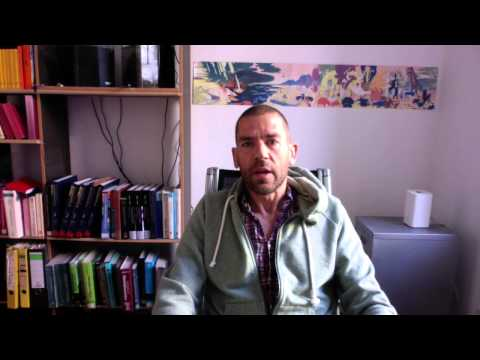

In [7]:
MoocVideo("NY6wPiH0E9E", src_location="9.2-summary")

Questions about what you just learned? Ask them below!

In [8]:
MoocDiscussion("Questions", "Topological scaling")

MoocDiscussion(**{'display_name': 'Topological scaling', 'discussion_target': 'Topological scaling', 'discussion_id': 'c97b8561f162343642c9a74f3214bf1e', 'discussion_category': 'Questions'})